# Late Fusion Model (Weighted Only) with Normalized Modalities

This notebook implements **weighted late fusion** combining:
- **Physiological data** (pupil metrics) - normalized with StandardScaler
- **Behavioral data** (reaction time, decision time, etc.) - normalized with StandardScaler
- **Gaze data** (gaze position, movements, fixations) - normalized with StandardScaler

**Key Change**: Uses **Logistic Regression** as base models instead of Random Forest.
- Logistic Regression is sensitive to feature scaling, so normalization matters
- Random Forest is scale-invariant (tree-based splits don't depend on magnitude)

**Parameterized**: Set `TIMEFRAME` to run PRE or POST analysis.

Goals:
1. Normalize all modality features with StandardScaler
2. Train separate Logistic Regression models for each modality
3. Implement weighted late fusion
4. Extract weights to estimate modality influence on predictions

In [1]:
# ============================================================================
# CONFIGURATION: Set timeframe for analysis
# ============================================================================
TIMEFRAME = 'PRE'  # Options: 'PRE', 'POST'
# ============================================================================

import sys
sys.path.append('../../..')  # Add project root to path

import json
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Import from src package
from src.utils.io import load_features, save_results
from src.utils.config import get_model_params, load_config
from src.utils.validation import validate_features, validate_modality_features
from src.models.fusion import weighted_late_fusion
from src.visualization.plots import (
    plot_method_comparison,
    plot_modality_weights,
    set_style
)

np.random.seed(42)
set_style('whitegrid')  # Use shared style function

print(f"\n{'='*70}")
print(f"WEIGHTED LATE FUSION WITH NORMALIZED MODALITIES: {TIMEFRAME}-DECISION PERIOD")
print(f"{'='*70}\n")


WEIGHTED LATE FUSION WITH NORMALIZED MODALITIES: PRE-DECISION PERIOD



## 1. Load Pre-Extracted Features

In [2]:
# Load configuration
config = load_config('model_params')
time_window = config['time_windows'][f'{TIMEFRAME.lower()}_decision']

print(f"Time window: {time_window['start']}s to {time_window['end']}s")
print(f"Description: {time_window['description']}\n")

# Load pre-extracted features
features_path = f'../../../data/results/features_{TIMEFRAME}/extracted_features_{TIMEFRAME}.pkl'
feature_data = load_features(features_path, timeframe=TIMEFRAME)

merged_df = feature_data['merged_df']
physio_cols = feature_data['physio_cols']
behavior_cols = feature_data['behavior_cols']
gaze_cols = feature_data['gaze_cols']

# Validate loaded features
validate_features(merged_df, timeframe=TIMEFRAME)

print(f"  Features extracted on: {feature_data['metadata']['extraction_date']}")
if 'baseline_method' in feature_data['metadata']:
    print(f"  Baseline method: {feature_data['metadata']['baseline_method']}")
print(f"\nFeature counts:")
print(f"  Physiology ({TIMEFRAME}): {len(physio_cols)} features")
print(f"  Behavior: {len(behavior_cols)} features")
print(f"  Gaze: {len(gaze_cols)} features")

Time window: -2.0s to 0.0s
Description: Anticipatory period before submit button

✓ Validation passed (PRE): 12511 trials, 97 subjects
  Trials per subject: min=9, max=246, mean=129.0
  Outcome balance: 4273 keep / 8238 invest
  Features extracted on: 2026-01-10 14:16:16
  Baseline method: t3_stable_pre_decision

Feature counts:
  Physiology (PRE): 13 features
  Behavior: 7 features
  Gaze: 20 features


## 2. Prepare and Normalize Feature Sets

**Normalization Strategy:**
- **Physiology**: StandardScaler normalization (now normalized for Logistic Regression)
- **Behavior**: StandardScaler normalization
- **Gaze**: StandardScaler normalization

All modalities are normalized because Logistic Regression is sensitive to feature scaling.

In [3]:
# Prepare feature arrays - ALL modalities normalized for Logistic Regression

# Physiology: Impute then normalize
X_physio_imputed = SimpleImputer(strategy='mean').fit_transform(merged_df[physio_cols])
scaler_physio = StandardScaler()
X_physio = scaler_physio.fit_transform(X_physio_imputed)

# Behavior: Impute then normalize
X_behavior_imputed = SimpleImputer(strategy='mean').fit_transform(merged_df[behavior_cols])
scaler_behavior = StandardScaler()
X_behavior = scaler_behavior.fit_transform(X_behavior_imputed)

# Gaze: Impute then normalize (if available)
if len(gaze_cols) > 0:
    X_gaze_imputed = SimpleImputer(strategy='mean').fit_transform(merged_df[gaze_cols])
    scaler_gaze = StandardScaler()
    X_gaze = scaler_gaze.fit_transform(X_gaze_imputed)
else:
    # Create placeholder array for POST condition (no gaze data)
    X_gaze = np.zeros((len(merged_df), 1))

y = merged_df['outcome'].values
subjects = merged_df['subject_id'].values

print(f"Shapes after normalization:")
print(f"  X_physio (normalized):   {X_physio.shape}")
print(f"  X_behavior (normalized): {X_behavior.shape}")
print(f"  X_gaze (normalized):     {X_gaze.shape}")

# Verify normalization
print(f"\nNormalization check (mean ≈ 0, std ≈ 1):")
print(f"  Physiology mean: {X_physio.mean():.4f}, std: {X_physio.std():.4f}")
print(f"  Behavior mean:   {X_behavior.mean():.4f}, std: {X_behavior.std():.4f}")
if len(gaze_cols) > 0:
    print(f"  Gaze mean:       {X_gaze.mean():.4f}, std: {X_gaze.std():.4f}")

Shapes after normalization:
  X_physio (normalized):   (12511, 13)
  X_behavior (normalized): (12511, 7)
  X_gaze (normalized):     (12511, 20)

Normalization check (mean ≈ 0, std ≈ 1):
  Physiology mean: 0.0000, std: 1.0000
  Behavior mean:   -0.0000, std: 1.0000
  Gaze mean:       -0.0000, std: 0.9747


In [4]:
def train_evaluate_modality(X, y, subjects, modality_name):
    """
    Train and evaluate a single modality using LOSO cross-validation.
    Uses Logistic Regression (scale-sensitive) instead of Random Forest.
    
    Parameters
    ----------
    X : np.ndarray
        Feature matrix for the modality, shape (n_samples, n_features)
    y : np.ndarray
        Target labels, shape (n_samples,)
    subjects : np.ndarray
        Subject IDs for each sample, shape (n_samples,)
    modality_name : str
        Name of the modality (for display purposes)
    
    Returns
    -------
    tuple
        (model, accuracy, f1_score, predictions, y_true)
    """
    logo = LeaveOneGroupOut()
    
    # Initialize storage
    all_preds = []
    all_y_true = []
    subject_accs = []
    subject_f1s = []
    
    print(f"\n{'='*50}")
    print(f"{modality_name} Model (Logistic Regression, Normalized)")
    print(f"{'='*50}")
    
    # LOSO cross-validation
    for train_idx, test_idx in logo.split(X, y, subjects):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Train Logistic Regression model (scale-sensitive!)
        model = LogisticRegression(
            max_iter=1000,
            class_weight='balanced',
            random_state=42,
            solver='lbfgs'
        )
        model.fit(X_train, y_train)
        
        # Predict
        y_pred = model.predict(X_test)
        
        # Store results
        all_preds.extend(y_pred)
        all_y_true.extend(y_test)
        
        # Subject-level metrics
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
        subject_accs.append(acc)
        subject_f1s.append(f1)
    
    # Calculate overall metrics
    overall_acc = np.mean(subject_accs)
    overall_f1 = np.mean(subject_f1s)
    
    print(f"Accuracy: {overall_acc:.3f} ± {stats.sem(subject_accs):.3f}")
    print(f"F1-Score: {overall_f1:.3f} ± {stats.sem(subject_f1s):.3f}")
    print(f"N subjects: {len(subject_accs)}")
    
    return model, overall_acc, overall_f1, np.array(all_preds), np.array(all_y_true)

## 3. Train Individual Modality Models

In [5]:
model_physio, acc_physio, f1_physio, pred_physio, y_true = train_evaluate_modality(
    X_physio, y, subjects, "Physiology"
)
model_behavior, acc_behavior, f1_behavior, pred_behavior, _ = train_evaluate_modality(
    X_behavior, y, subjects, "Behavior"
)

# Only train gaze model if gaze data exists
if len(gaze_cols) > 0:
    model_gaze, acc_gaze, f1_gaze, pred_gaze, _ = train_evaluate_modality(
        X_gaze, y, subjects, "Gaze"
    )
else:
    # Placeholder for POST (no gaze data)
    model_gaze = None
    acc_gaze = 0.5
    f1_gaze = 0.5
    pred_gaze = np.zeros(len(y))
    print(f"\n{'='*50}\nGaze Model\n{'='*50}")
    print("Skipping - no gaze data available (POST condition)")


Physiology Model (Logistic Regression, Normalized)
Accuracy: 0.536 ± 0.014
F1-Score: 0.525 ± 0.017
N subjects: 97

Behavior Model (Logistic Regression, Normalized)
Accuracy: 0.647 ± 0.013
F1-Score: 0.668 ± 0.013
N subjects: 97

Gaze Model (Logistic Regression, Normalized)
Accuracy: 0.500 ± 0.016
F1-Score: 0.472 ± 0.019
N subjects: 97


## 4. Weighted Late Fusion Implementation

Custom implementation using **Logistic Regression** as base models (scale-sensitive) instead of Random Forest.

In [6]:
def weighted_late_fusion_logreg(X_modalities, y, subjects, modality_names):
    """
    Weighted late fusion using Logistic Regression base models.
    This is scale-sensitive, so normalization matters!
    """
    from sklearn.model_selection import GroupKFold
    
    logo = LeaveOneGroupOut()
    
    # Store subject-level results
    subject_accs = {}
    subject_f1s = {}
    all_weights = []
    preds_all = []
    y_true_all = []
    
    # LOSO cross-validation
    for train_idx, test_idx in logo.split(X_modalities[0], y, subjects):
        y_train, y_test = y[train_idx], y[test_idx]
        train_subjects = subjects[train_idx]
        
        # Get out-of-fold predictions for meta-learner training
        train_probs = np.zeros((len(train_idx), len(X_modalities)))
        
        # Nested 5-fold within training set
        gkf_inner = GroupKFold(n_splits=5)
        for inner_train_idx, inner_val_idx in gkf_inner.split(
            X_modalities[0][train_idx], y_train, train_subjects
        ):
            abs_inner_train = train_idx[inner_train_idx]
            abs_inner_val = train_idx[inner_val_idx]
            
            # Train Logistic Regression base models
            for mod_i, X in enumerate(X_modalities):
                model = LogisticRegression(
                    max_iter=1000,
                    class_weight='balanced',
                    random_state=42
                )
                model.fit(X[abs_inner_train], y[abs_inner_train])
                train_probs[inner_val_idx, mod_i] = model.predict_proba(X[abs_inner_val])[:, 1]
        
        # Train base models on full training set and get test predictions
        test_probs = []
        for X in X_modalities:
            X_train, X_test = X[train_idx], X[test_idx]
            model = LogisticRegression(
                max_iter=1000,
                class_weight='balanced',
                random_state=42
            )
            model.fit(X_train, y_train)
            test_probs.append(model.predict_proba(X_test)[:, 1])
        
        test_probs = np.column_stack(test_probs)
        
        # Meta-learner (Logistic Regression)
        meta = LogisticRegression(random_state=42, max_iter=1000)
        meta.fit(train_probs, y_train)
        weights = meta.coef_[0]
        y_pred = meta.predict(test_probs)
        
        # Store subject-level metrics
        test_subject = subjects[test_idx][0]
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
        subject_accs[test_subject] = acc
        subject_f1s[test_subject] = f1
        all_weights.append(weights)
        preds_all.extend(y_pred)
        y_true_all.extend(y_test)
    
    # Average and normalize weights
    avg_weights = np.mean(all_weights, axis=0)
    norm_weights = np.exp(avg_weights) / np.sum(np.exp(avg_weights))  # Softmax
    
    subject_acc_values = np.array(list(subject_accs.values()))
    subject_f1_values = np.array(list(subject_f1s.values()))
    
    return {
        'accuracy_mean': np.mean(subject_acc_values),
        'accuracy_sem': stats.sem(subject_acc_values),
        'f1_mean': np.mean(subject_f1_values),
        'f1_sem': stats.sem(subject_f1_values),
        'weights': norm_weights,
        'n_subjects': len(subject_accs),
        'n_trials': len(y),
        'subject_accs': subject_accs,
        'subject_f1s': subject_f1s
    }

# Prepare modality lists
if len(gaze_cols) > 0:
    X_modalities = [X_physio, X_behavior, X_gaze]
    modality_names = ['Physiology', 'Behavior', 'Gaze']
else:
    X_modalities = [X_physio, X_behavior]
    modality_names = ['Physiology', 'Behavior']

# Validate modalities before fusion
validate_modality_features(X_modalities, y, subjects, modality_names)

print("\nRunning weighted late fusion with Logistic Regression base models...")
print("(Normalization now matters because LR is scale-sensitive!)\n")
results_weighted = weighted_late_fusion_logreg(X_modalities, y, subjects, modality_names)

print(f"\n{'='*50}")
print("WEIGHTED FUSION RESULTS (Logistic Regression)")
print(f"{'='*50}")
print(f"Accuracy: {results_weighted['accuracy_mean']:.3f} ± {results_weighted['accuracy_sem']:.3f}")
print(f"F1-Score: {results_weighted['f1_mean']:.3f} ± {results_weighted['f1_sem']:.3f}")
print(f"N Subjects: {results_weighted['n_subjects']}")
print(f"N Trials: {results_weighted['n_trials']}")

✓ Modality validation passed:
  Physiology: 12511 samples × 13 features
  Behavior: 12511 samples × 7 features
  Gaze: 12511 samples × 20 features

Running weighted late fusion with Logistic Regression base models...
(Normalization now matters because LR is scale-sensitive!)


WEIGHTED FUSION RESULTS (Logistic Regression)
Accuracy: 0.683 ± 0.015
F1-Score: 0.660 ± 0.018
N Subjects: 97
N Trials: 12511


## 5. Results Summary


PERFORMANCE COMPARISON (PRE) - NORMALIZED MODALITIES
                      Method  Accuracy  F1-Score
             Physiology Only  0.535520  0.524976
               Behavior Only  0.646900  0.667909
                   Gaze Only  0.499517  0.471873
Weighted Fusion (Normalized)  0.682502  0.660378


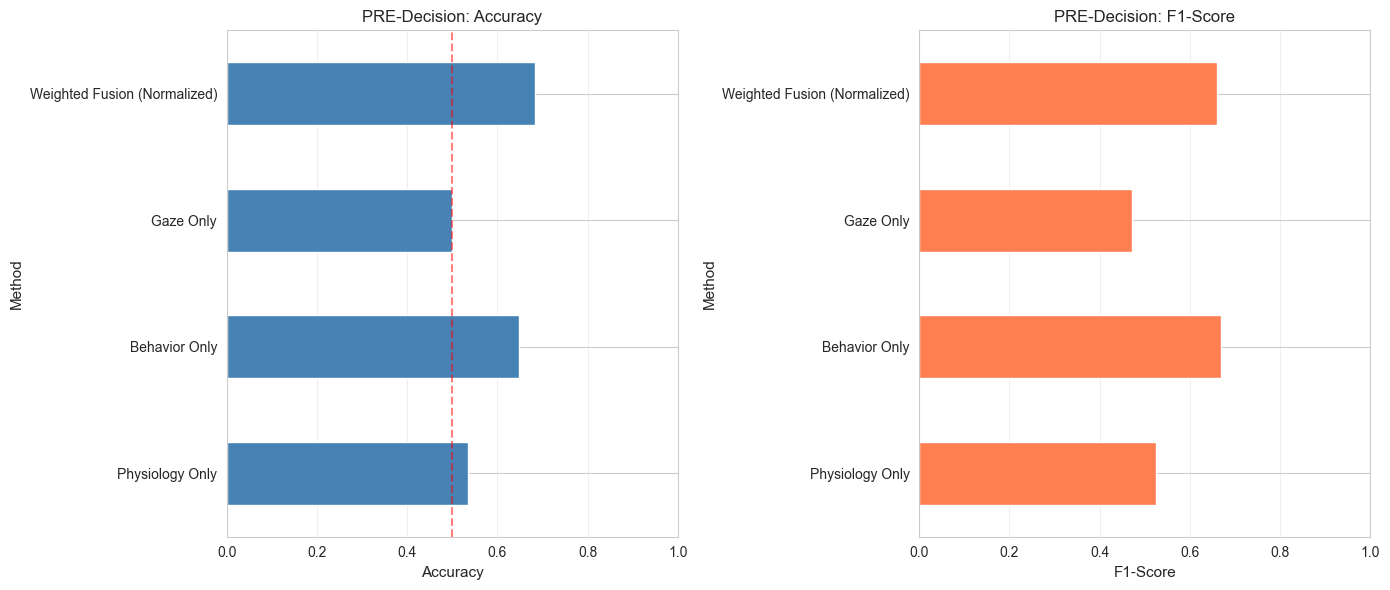

In [7]:
# Build comparison dataframe
comparison_data = {
    'Method': ['Physiology Only', 'Behavior Only'],
    'Accuracy': [acc_physio, acc_behavior],
    'F1-Score': [f1_physio, f1_behavior]
}

# Add gaze if available
if len(gaze_cols) > 0:
    comparison_data['Method'].append('Gaze Only')
    comparison_data['Accuracy'].append(acc_gaze)
    comparison_data['F1-Score'].append(f1_gaze)

# Add weighted fusion
comparison_data['Method'].append('Weighted Fusion (Normalized)')
comparison_data['Accuracy'].append(results_weighted['accuracy_mean'])
comparison_data['F1-Score'].append(results_weighted['f1_mean'])

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*70)
print(f"PERFORMANCE COMPARISON ({TIMEFRAME}) - NORMALIZED MODALITIES")
print("="*70)
print(comparison_df.to_string(index=False))

# Use shared plotting function
fig = plot_method_comparison(comparison_df, timeframe=TIMEFRAME)
plt.show()

## 6. Modality Contribution Analysis


MODALITY CONTRIBUTIONS (Weighted Fusion)
  Modality   Weight  Percentage
Physiology 0.099772    9.977160
  Behavior 0.894382   89.438206
      Gaze 0.005846    0.584633


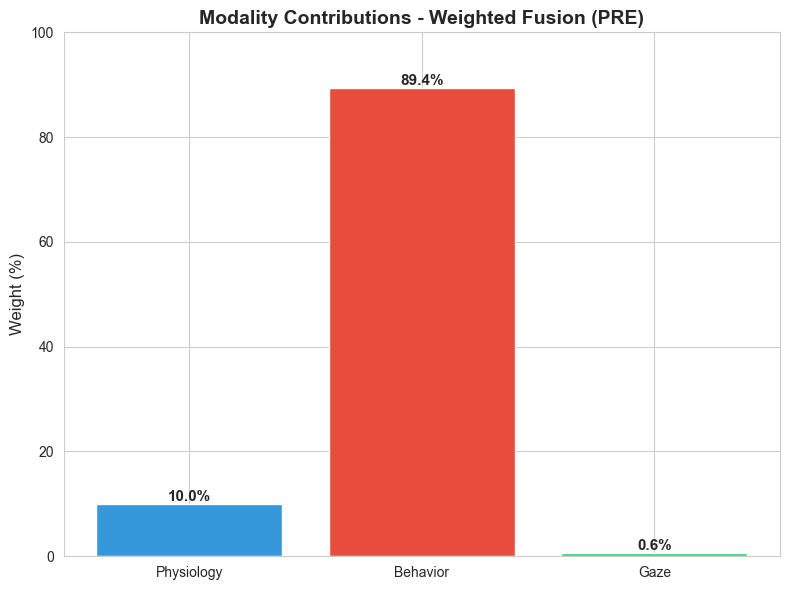

In [8]:
# Create weights dataframe (only weighted method)
weights_df = pd.DataFrame({
    'Modality': modality_names,
    'Weight': results_weighted['weights'],
    'Percentage': results_weighted['weights'] * 100
})

print("\n" + "="*50)
print("MODALITY CONTRIBUTIONS (Weighted Fusion)")
print("="*50)
print(weights_df.to_string(index=False))

# Visualization
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(weights_df['Modality'], weights_df['Percentage'], color=['#3498db', '#e74c3c', '#2ecc71'][:len(modality_names)])
ax.set_ylabel('Weight (%)', fontsize=12)
ax.set_title(f'Modality Contributions - Weighted Fusion ({TIMEFRAME})', fontsize=14, fontweight='bold')
ax.set_ylim(0, 100)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}%',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

## 7. Summary Statistics

In [9]:
print("\n" + "="*70)
print(f"SUMMARY ({TIMEFRAME}-DECISION) - NORMALIZED + LOGISTIC REGRESSION")
print("="*70)

print("\n1. INDIVIDUAL MODALITIES (Logistic Regression, all normalized):")
print(f"   Physiology:  Acc={acc_physio:.3f}, F1={f1_physio:.3f}")
print(f"   Behavior:    Acc={acc_behavior:.3f}, F1={f1_behavior:.3f}")
if len(gaze_cols) > 0:
    print(f"   Gaze:        Acc={acc_gaze:.3f}, F1={f1_gaze:.3f}")
else:
    print(f"   Gaze:        Not available (POST condition)")

print("\n2. WEIGHTED LATE FUSION (Logistic Regression base models):")
print(f"   Accuracy:    {results_weighted['accuracy_mean']:.3f} ± {results_weighted['accuracy_sem']:.3f}")
print(f"   F1-Score:    {results_weighted['f1_mean']:.3f} ± {results_weighted['f1_sem']:.3f}")
print(f"   N Subjects:  {results_weighted['n_subjects']}")
print(f"   N Trials:    {results_weighted['n_trials']}")

print("\n3. MODALITY CONTRIBUTIONS:")
for name, w in zip(modality_names, results_weighted['weights']):
    print(f"   {name:12s}: {w*100:5.1f}%")

best = comparison_df.loc[comparison_df['Accuracy'].idxmax()]
print(f"\n4. BEST METHOD: {best['Method']} (Acc={best['Accuracy']:.3f})")

print("\nNote: Using Logistic Regression (scale-sensitive) means normalization")
print("      actually affects results, unlike Random Forest (scale-invariant).")
print("\n" + "="*70)


SUMMARY (PRE-DECISION) - NORMALIZED + LOGISTIC REGRESSION

1. INDIVIDUAL MODALITIES (Logistic Regression, all normalized):
   Physiology:  Acc=0.536, F1=0.525
   Behavior:    Acc=0.647, F1=0.668
   Gaze:        Acc=0.500, F1=0.472

2. WEIGHTED LATE FUSION (Logistic Regression base models):
   Accuracy:    0.683 ± 0.015
   F1-Score:    0.660 ± 0.018
   N Subjects:  97
   N Trials:    12511

3. MODALITY CONTRIBUTIONS:
   Physiology  :  10.0%
   Behavior    :  89.4%
   Gaze        :   0.6%

4. BEST METHOD: Weighted Fusion (Normalized) (Acc=0.683)

Note: Using Logistic Regression (scale-sensitive) means normalization
      actually affects results, unlike Random Forest (scale-invariant).



## 8. Save Results

In [10]:
# Save results using shared utility
import os
output_dir = f'../../../data/results/fusion_model_normalized_{TIMEFRAME}'
os.makedirs(output_dir, exist_ok=True)

# 1. Save method comparison results
save_results(comparison_df, 
             f'{output_dir}/late_fusion_normalized_{TIMEFRAME}_method_comparison.csv')

# 2. Save modality weights
save_results(weights_df,
             f'{output_dir}/late_fusion_normalized_{TIMEFRAME}_modality_weights.csv')

# 3. Save weighted fusion summary
weighted_summary = pd.DataFrame({
    'Metric': ['Accuracy', 'Accuracy_SEM', 'F1_Score', 'F1_SEM', 'N_Subjects', 'N_Trials', 'Base_Model'],
    'Value': [
        results_weighted['accuracy_mean'],
        results_weighted['accuracy_sem'],
        results_weighted['f1_mean'],
        results_weighted['f1_sem'],
        results_weighted['n_subjects'],
        results_weighted['n_trials'],
        'LogisticRegression'
    ]
})
save_results(weighted_summary,
             f'{output_dir}/late_fusion_normalized_{TIMEFRAME}_weighted_fusion_summary.csv')

# 4. Save subject-level accuracies
subject_df = pd.DataFrame({
    'subject_id': list(results_weighted['subject_accs'].keys()),
    'accuracy': list(results_weighted['subject_accs'].values())
})
save_results(subject_df,
             f'{output_dir}/late_fusion_normalized_{TIMEFRAME}_subject_accuracies.csv')
print(f"  - {len(subject_df)} subjects, Mean accuracy: {subject_df['accuracy'].mean():.4f}")

# 5. Save normalization info
norm_info = pd.DataFrame({
    'Modality': ['Physiology', 'Behavior', 'Gaze'],
    'Normalized': ['Yes (StandardScaler)', 'Yes (StandardScaler)', 
                   'Yes (StandardScaler)' if len(gaze_cols) > 0 else 'N/A'],
    'Base_Model': ['LogisticRegression', 'LogisticRegression', 
                   'LogisticRegression' if len(gaze_cols) > 0 else 'N/A']
})
save_results(norm_info,
             f'{output_dir}/late_fusion_normalized_{TIMEFRAME}_normalization_info.csv')

print(f"\n✓ All results saved to: {output_dir}/")

✓ Saved results to: ../../../data/results/fusion_model_normalized_PRE/late_fusion_normalized_PRE_method_comparison.csv
✓ Saved results to: ../../../data/results/fusion_model_normalized_PRE/late_fusion_normalized_PRE_modality_weights.csv
✓ Saved results to: ../../../data/results/fusion_model_normalized_PRE/late_fusion_normalized_PRE_weighted_fusion_summary.csv
✓ Saved results to: ../../../data/results/fusion_model_normalized_PRE/late_fusion_normalized_PRE_subject_accuracies.csv
  - 97 subjects, Mean accuracy: 0.6825
✓ Saved results to: ../../../data/results/fusion_model_normalized_PRE/late_fusion_normalized_PRE_normalization_info.csv

✓ All results saved to: ../../../data/results/fusion_model_normalized_PRE/
